## Multi-Index Search

##### Note: This example requires a KDB.AI endpoint and API key. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

KDB.AI enables multiple indexes to be defined within a table. The indexes can be queried and searched independently, or simultaneously. When doing multi-index search, the user defines a 'weight' parameter to determine the weight of each index for that search.

In this example we will highlight multi-index search with a multimodal retrieval use-case. We will take images of animals with text descriptions, embed both of them with the CLIP multimodal model, store the image embeddings in one index, and the text embeddings in another index, and perform multi-index search.

### Agenda:
1. Setup
2. Generate Image and Text Embeddings Using CLIP
3. Define KDB.AI Session
4. Define Vector DB Table Schema
5. Create Vector DB Table
6. Insert DataFrame into the KDB.AI Table
7. Execute Multi-Index Search
8. Delete the KDB.AI Table

Animal Images Source: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

## 1. Dependencies, Imports & Setup

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [ ]:
!pip install kdbai_client

In [ ]:
# For CPU-only
!pip install torch torchvision

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [4]:
import clip
import torch
import kdbai_client as kdbai

In [ ]:
import os
import requests
import io
from PIL import Image
### !!! Only run this cell if you need to download the data into your environment, for example in Colab
### This downloads image and text data

!mkdir -p ./data


def get_github_repo_contents(repo_owner, repo_name, branch, folder_path):
    # Construct the API URL
    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"

    # Send the request and process the response
    contents = requests.get(api_url).json()

    # Create the local directory if it doesn't exist
    fPath = f"./{folder_path.split('/')[-1]}"

    for item in contents:
        # Recursively list contents of subfolder
        if item['type'] == 'dir':
            get_github_repo_contents(repo_owner, repo_name, branch, f"{folder_path}/{item['name']}")
        # Download and save file
        elif item['type'] == 'file':
            file_url = f"https://raw.githubusercontent.com/{repo_owner}/{repo_name}/{branch}/{folder_path}/{item['name']}"
            print(file_url)
            r = requests.get(file_url, timeout=4.0)
            r.raise_for_status()  # Raises an exception for HTTP errors
            file_path = f"{fPath}/{item['name']}"

            if item['name'].lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Save image file
                with Image.open(io.BytesIO(r.content)) as im:
                    im.save(file_path)
            else:
                # Save text file
                with open(file_path, 'wb') as f:
                    f.write(r.content)

# Get images and texts
get_github_repo_contents(
    #repo_owner='KxSystems',
    #repo_name='kdbai-samples',
    #branch='main',
    #folder_path='multi_index_multimodal_search/data'
    repo_owner='RyanSieglerKX',
    repo_name='kdbai-samples',
    branch='KDBAI_Updates_1_4',
    folder_path='multi_index_multimodal_search'
)

## 2. Generate Image and Text Embeddings Using CLIP

In [8]:
import torch
from PIL import Image
import clip
import os
import pandas as pd
import numpy as np

def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess, device

def generate_image_embedding(model, preprocess, image_path, device):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features.cpu().numpy()

def generate_text_embedding(model, text, device):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    return text_features.cpu().numpy()

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read().strip()

def process_images_and_descriptions(data_dir):
    model, preprocess, device = load_clip_model()

    data = []

    # First, collect all image files
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    for image_file in image_files:
        image_path = os.path.join(data_dir, image_file)
        text_file = os.path.splitext(image_file)[0] + '.txt'
        text_path = os.path.join(data_dir, text_file)

        image_embedding = generate_image_embedding(model, preprocess, image_path, device)

        if os.path.exists(text_path):
            text = read_text_file(text_path)
            text_embedding = generate_text_embedding(model, text, device)
        else:
            text = None
            text_embedding = None

        data.append({
            'image_path': image_path,
            'text_path': text_path if os.path.exists(text_path) else None,
            'text': text,
            'image_embedding': image_embedding.flatten(),
            'text_embedding': text_embedding.flatten() if text_embedding is not None else None
        })

    # Create DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage
data_dir = "/content/data"
result_df = process_images_and_descriptions(data_dir)

# Display the first few rows of the DataFrame
print(result_df.head())


100%|███████████████████████████████████████| 338M/338M [00:35<00:00, 10.1MiB/s]


                       image_path                       text_path  \
0         /content/data/bear1.jpg         /content/data/bear1.txt   
1  /content/data/caterpillar1.jpg  /content/data/caterpillar1.txt   
2         /content/data/bear2.jpg         /content/data/bear2.txt   
3          /content/data/fox2.jpg          /content/data/fox2.txt   
4          /content/data/bat1.jpg          /content/data/bat1.txt   

                                                text  \
0  Brown bear walking through a forest with falle...   
1       Bright green caterpillar on a wooden surface   
2  Close-up portrait of a grizzly bear's face and...   
3  Red fox with alert expression against rocky ba...   
4  Bat with outstretched wings hovering over an a...   

                                     image_embedding  \
0  [0.3652942, -0.5097397, -0.14261313, 0.1364640...   
1  [0.027902357, -0.19691387, -0.1773517, -0.3578...   
2  [0.41493368, -0.5950427, -0.25015795, -0.06186...   
3  [0.16643637, -0.21716

## 3. Define KDB.AI Session

KDB.AI comes in two offerings:

1. [KDB.AI Cloud](https://trykdb.kx.com/kdbai/signup/) - For experimenting with smaller generative AI projects with a vector database in our cloud.
2. [KDB.AI Server](https://trykdb.kx.com/kdbaiserver/signup/) - For evaluating large scale generative AI applications on-premises or on your own cloud provider.

Depending on which you use there will be different setup steps and connection details required.

##### Option 1. KDB.AI Cloud

To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key.
To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI Cloud session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [ ]:
from getpass import getpass

KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

##### Option 2. KDB.AI Server

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/).

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.

In [ ]:
# session = kdbai.Session(endpoint="http://localhost:8082")

## 4. Define Vector DB Table Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will have two columns.

At this point you will select the index and metric you want to use for searching.

In this case, we will use the qFlat index, Euclidean Distance (L2) for the search metric, and we specify the number of dimensions of our embeddings (512)

In [10]:
#Set up the schema and indexes for KDB.AI table
schema = [
    {"name": "image_path", "type": "str"},
    {"name": "text_path", "type": "str"},
    {"name": "text", "type": "str"},
    {"name": "image_embedding", "type": "float32s"},
    {"name": "text_embedding", "type": "float32s"}
]

indexes = [
    {
        "name": "image_index_qFlat",
        "type": "qFlat",
        "column": "image_embedding",
        "params": {"dims": 512, "metric": "L2"},
    },
    {
        "name": "text_index_qFlat",
        "type": "qFlat",
        "column": "text_embedding",
        "params": {"dims": 512, "metric": "L2"},
    },
]

## 5. Create Vector DB Table

Use the KDB.AI `create_table` function to create a table that matches the defined schema in the vector database.

In [11]:
# get the database connection. Default database name is 'default'
database = session.database('default')

# First ensure the table does not already exist
try:
    database.table("multi_index_search").drop()
except kdbai.KDBAIException:
    pass

table = database.create_table("multi_index_search", schema, indexes=indexes)

We can use `query` to see our table exists but is empty.

In [12]:
table.query()

,image_path,text_path,text,image_embedding,text_embedding


## 6. Insert DataFrame into the KDB.AI Table

In [13]:
table.insert(result_df)

{'rowsInserted': 12}

Let's check if the data was ingested into the table:

In [14]:
table.query()

,image_path,text_path,text,image_embedding,text_embedding
0,/content/data/bear1.jpg,/content/data/bear1.txt,Brown bear walking through a forest with falle...,"[0.3652942, -0.5097397, -0.14261313, 0.1364640...","[0.26745114, -0.25292325, 0.28568617, 0.197531..."
1,/content/data/caterpillar1.jpg,/content/data/caterpillar1.txt,Bright green caterpillar on a wooden surface,"[0.027902357, -0.19691387, -0.1773517, -0.3578...","[0.123128995, -0.30758965, -0.14478153, -0.123..."
2,/content/data/bear2.jpg,/content/data/bear2.txt,Close-up portrait of a grizzly bear's face and...,"[0.41493368, -0.5950427, -0.25015795, -0.06186...","[0.33882046, -0.5305982, -0.19989716, 0.027410..."
3,/content/data/fox2.jpg,/content/data/fox2.txt,Red fox with alert expression against rocky ba...,"[0.16643637, -0.21716054, 0.07092037, -0.19815...","[0.1648786, -0.18653345, -0.07513559, -0.18942..."
4,/content/data/bat1.jpg,/content/data/bat1.txt,Bat with outstretched wings hovering over an a...,"[1.0074518, 0.31929398, -0.11571782, 0.0093073...","[0.22833444, 0.22506703, 0.044606645, -0.07034..."
5,/content/data/deer2.jpg,/content/data/deer2.txt,Side view of buck deer with large antlers in f...,"[0.4866862, 0.00026917376, -0.16669051, -0.161...","[0.02772035, 0.11909036, 0.035442483, -0.02868..."
6,/content/data/hedgehog2.jpg,/content/data/hedgehog2.txt,"Hedgehog in a field of red flowers, some petal...","[-0.045391265, -0.2331721, -0.3230513, 0.14903...","[-0.26024696, -0.16443783, 0.23179547, 0.16231..."
7,/content/data/bat2.jpg,/content/data/bat2.txt,a bat hanging upside down from a metal bar in ...,"[1.0908129, 0.0474595, -0.32392886, -0.2873495...","[0.31573105, 0.24954566, -0.081122495, -0.1514..."
8,/content/data/caterpillar2.jpg,/content/data/caterpillar2.txt,Hairy caterpillar with spikes and spots on a g...,"[0.8352519, -0.41040668, -0.10877056, -0.07437...","[0.1643652, -0.51153654, -0.16145216, -0.24558..."
9,/content/data/fox1.jpg,/content/data/fox1.txt,Fluffy fox curled up in snow with eyes closed,"[0.17853464, 0.015229732, 0.05193204, -0.30552...","[-0.3330847, 0.18723154, -0.024400767, -0.0526..."


## 7. Execute Multi-Index Search
Now, our table is all set up to search against. We will perform searches for images, text, as well as multimodal search across both, demonstrating multi-index search.

In [15]:
from IPython.display import display

def embed_query(text):
    model, preprocess, device = load_clip_model()
    # Tokenize the text
    text_tokens = clip.tokenize([text]).to(device)

    # Generate the embedding
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)

    # Convert to numpy array and return
    return text_features.cpu().numpy()


def view_results(results):
  for index, row in results.iterrows():
      display(Image.open(row.iloc[1]))
      print(row.iloc[3])

In [19]:
query = 'what are the purpose of antlers?'

In [20]:
query_vector = embed_query(query)

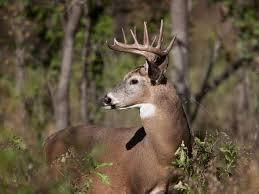

Side view of buck deer with large antlers in forest setting


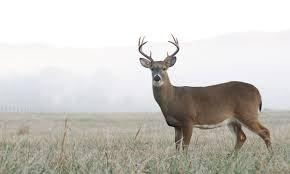

Buck deer with antlers standing in misty grassland


In [21]:
# Search across the texts index
results = table.search(vectors={"text_index_qFlat":query_vector},n=2)[0]
view_results(results)

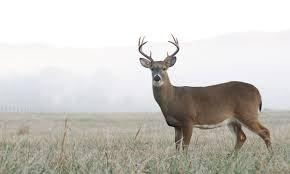

Buck deer with antlers standing in misty grassland


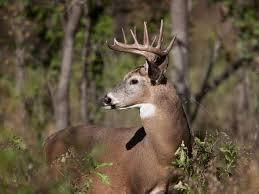

Side view of buck deer with large antlers in forest setting


In [22]:
# Search across the images index
view_results(table.search(vectors={"image_index_qFlat":query_vector},n=2)[0])

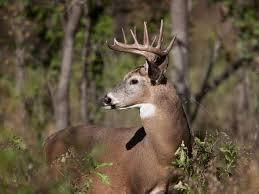

Side view of buck deer with large antlers in forest setting


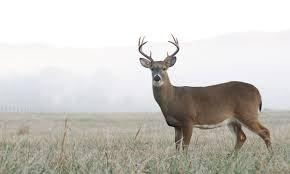

Buck deer with antlers standing in misty grassland


In [23]:
# Multi-Index Search for both texts and images
results = table.search(
    vectors={"text_index_qFlat":query_vector, "image_index_qFlat":query_vector},
    index_params={"text_index_qFlat":{'weight':0.5} ,"image_index_qFlat":{'weight':0.5}},
    n=2
    )[0]

view_results(results)

Let's try another example:

In [24]:
query = 'flying animal that eats bugs and fruit and hangs upsidedown'
query_vector = embed_query(query)

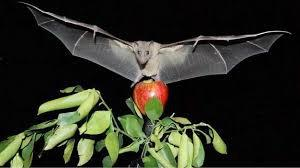

Bat with outstretched wings hovering over an apple on leafy branch


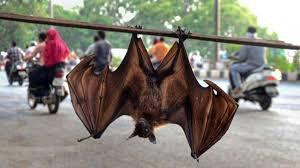

a bat hanging upside down from a metal bar in an urban setting


In [25]:
# Multi-Index Search for both texts and images
results = table.search(
    vectors={"text_index_qFlat":query_vector, "image_index_qFlat":query_vector},
    index_params={"text_index_qFlat":{'weight':0.5} ,"image_index_qFlat":{'weight':0.5}},
    n=2
    )[0]

view_results(results)

You could then pass these retrieved results to a multimodal LLM to perform multimodal RAG!

## 8. Delete the KDB.AI Table


In [ ]:
table.drop()

#### Take Our Survey
We hope you found this sample helpful! Your feedback is important to us, and we would appreciate it if you could take a moment to fill out our brief survey. Your input helps us improve our content.

Take the [Survey](https://delighted.com/t/U2RoT32R)
